<a href="https://colab.research.google.com/github/RaivoKasepuu/BDA_Tartu_MTAT_03_319/blob/master/Copy_of_bda_lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> <font color='black'> Business Data Analytics - Practice Session_06 </font></center></h1>
<h2><center> <font color='black'> Recommender systems</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>

## Introduction

**Recommender system:** is one of the most famous applications of data science and machine learning that provides help and support for bussiness companies.
    
    
   * Have you ever wondered how **Netflix** suggests movies to you based on the movies you have already watched? Or how does an **e-commerce** websites display options such as "Frequently Bought Together"? They may look relatively simple options but behind the scenes, a complex statistical algorithm executes in order to predict these recommendations. **Such systems are called Recommender Systems, Recommendation Systems, or Recommendation Engines.**
    
    
   * A **Recommender System** employs a statistical algorithm that seeks to predict users' ratings for a particular entity, based on the **similarity between the entities** or **similarity between the users** that previously rated those entities. The intuition is that similar types of users are likely to have similar ratings for a set of entities.


   * Currently, many of the big tech companies out there use a Recommender System in one way or another. You can find them anywhere from:
       * Amazon (product recommendations)
       * YouTube (video recommendations)
       * Facebook (friend recommendations).
       

## Types of Recommender Systems:


![types](https://lh3.google.com/u/0/d/135exKrDnixvr1Nts-bMPVOZ4gwHOU3p4=w1366-h625-iv1)

More info here: https://medium.com/@cfpinela/recommender-systems-user-based-and-item-based-collaborative-filtering-5d5f375a127f

In today's practice session we will talk about **Collaborative Filtering**

1. **Collaborative Filtering (CF):** We have two different types of **CF**: 
    
    1. **User-Based Collaborative Filtering (UB-CF)**
    2. **Item-Based Collaborative Filtering (IB-CF):**

## Item-Based Collaborative Filtering (IB-CF):

## DataSets
We will use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files  `movies.csv`, `ratings.csv`.


## Lab Session Content
1. Load data
2. Exploratory data analysis
3. Train KNN model for item-based collaborative filtering
4. Use this trained model to make movie recommendations to myself


## 1. Install packages
![step1](https://i.ibb.co/JmyLmCc/step1.png)

In [ ]:
# run if you don't have fuzzywuzzy
!pip install fuzzywuzzy

In [ ]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

## 2. Load Data

![step2](https://i.ibb.co/0fVTjwm/step2.png)

In [ ]:
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'


df_movies = pd.read_csv((movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv((ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})


In [ ]:
print(df_movies.head(), '\n')

print(df_ratings.head())

   movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995) 

   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int32 
 1   title    9125 non-null   object
dtypes: int32(1), object(1)
memory usage: 107.1+ KB


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int32  
 1   movieId  100004 non-null  int32  
 2   rating   100004 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [ ]:
num_users = len(df_ratings.userId.unique())  # unique users
num_items = len(df_ratings.movieId.unique()) # unique items (movies)
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 671 unique users and 9066 unique movies in this data set


### Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

In [ ]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


In [ ]:
df_ratings.head(25)

We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [ ]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5983282
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


The count for zero rating score is too big to compare with others. So let's take **log transform** for count values and then we can plot them to compare.

* A logarithmic scale is a nonlinear scale often used when analyzing a large range of quantities.
There are two main reasons to use logarithmic scales. The first is to respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data. The second is to show percent change or multiplicative factors.
Read more [here](https://energyeducation.ca/encyclopedia/Logarithmic_scale#:~:text=A%20logarithmic%20scale%20is%20a,base%20ten%20logarithmic%20plot%20is) and [here](https://www.forbes.com/sites/naomirobbins/2012/01/19/when-should-i-use-logarithmic-scales-in-my-charts-and-graphs/?sh=65d809fc5e67).

In [ ]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5983282,15.604480
0.5,1101,7.003974
1.0,3326,8.109526
1.5,1687,7.430707
2.0,7271,8.891649
2.5,4449,8.400435
3.0,20064,9.906682
3.5,10538,9.262743
4.0,28750,10.266393
4.5,7723,8.951958


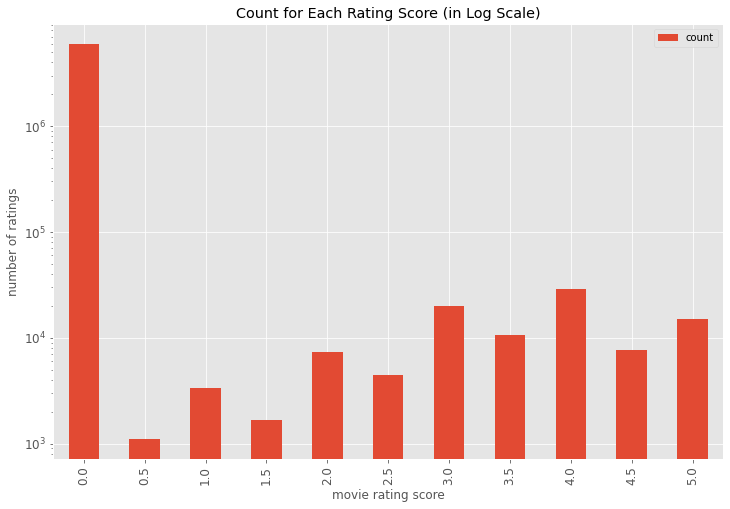

In [ ]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings");

#### 2. Plot rating frequency of all movies

In [ ]:
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [ ]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,247
2,107
3,59
4,13
5,56


In [ ]:
df_movies_cnt.describe()

,count
count,9066.000000
mean,11.030664
std,24.050800
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,341.000000


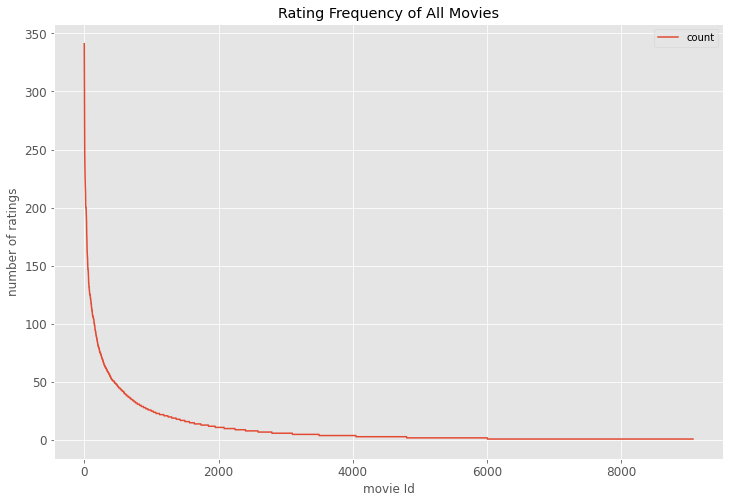

In [ ]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings");

The distribution of ratings among movies often satisfies a property in real-world settings,
which is referred to as the long-tail property. According to this property, only a small
fraction of the items are rated frequently. Such items are referred to as popular items. The
vast majority of items are rated rarely. This results in a highly skewed distribution of the
underlying ratings.

Let's plot the same distribution but with log scale

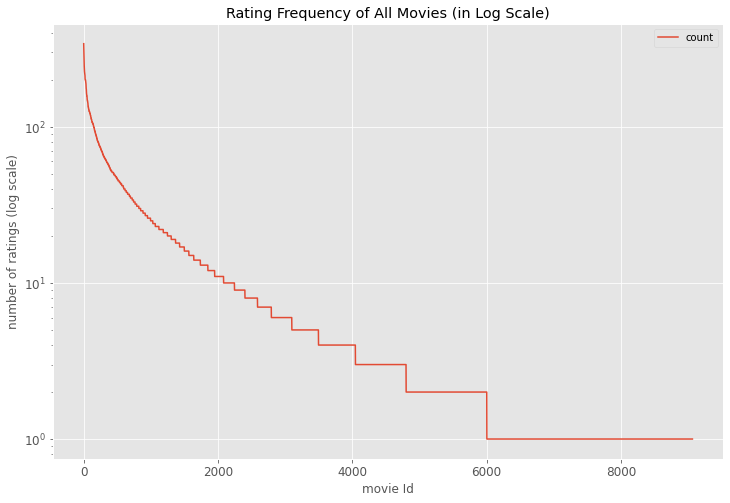

In [ ]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)");

We can see that roughly 10,000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [ ]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))
# do you remember what np.arange does and what are the arguments?
# (start, stop, step)

1.00    341.0
0.95     49.0
0.90     28.0
0.85     19.0
0.80     13.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.
 - Memory issue: we don't want to run into the “MemoryError” during model training
 - Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [ ]:
df_movies_cnt.head()

,count
movieId,
1,247
2,107
3,59
4,13
5,56


In [ ]:
# filter data
popularity_thres = 50
# get movies that have been rated more than 50 times
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
# create new df
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping unpopular movies:  (43083, 3)


After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [ ]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,3
2,56
3,30
4,106
5,76


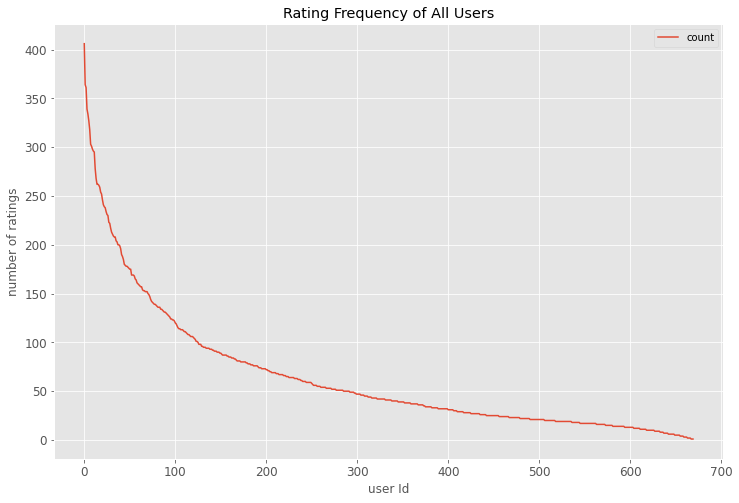

In [ ]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings");

In [ ]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    406.00
0.95    208.00
0.90    152.10
0.85    119.65
0.80     94.20
0.75     81.75
0.70     72.00
0.65     62.85
0.60     53.00
0.55     47.00
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 113,291 users.

In [ ]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (34044, 3)


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model
 
 ![steps34](https://i.ibb.co/VgSy5Gq/steps3-4.png)

**KNN**  is a supervised machine learning algorithm(output labels are provided) which solves both Classification and Regression problems.

![knn](https://miro.medium.com/max/591/1*gn48DrMdZLTulYSBAuxLCw.png)

Different ways to calculate the distance in KNN:

* Minkowski distance( Euclidean, Manhattan etc)
* Chebyshev distance
* Cosine Similarity
* Hamming distance

Now, There are two popular ways to find the value of K in K-NN:

* Elbow Curve
* Grid Search

More info here: https://medium.com/analytics-vidhya/k-nearest-neighbors-all-you-need-to-know-1333eb5f0ed0

Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an array, where each row is a movie and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [ ]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

In [ ]:
df_ratings_drop_users.head()

,userId,movieId,rating
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0
24,2,50,4.0


In [ ]:
movie_user_mat.head()

userId,2,4,5,7,8,15,17,19,20,21,22,23,26,30,34,36,41,42,43,48,56,57,59,61,63,67,68,69,72,73,75,77,78,83,84,85,86,88,89,91,...,570,574,575,577,580,582,584,585,587,590,592,593,594,595,596,597,598,602,603,605,607,608,615,620,623,624,626,627,641,646,647,648,649,654,655,659,662,664,665,671
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,3.5,0.0,0.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,5.0,3.0,4.0,5.0,3.5,5.0,3.0,4.0,0.0,0.0,3.5,0.0,3.0,0.0,5.0,5.0,...,1.5,4.0,3.0,5.0,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,5.0,3.5,5.0,4.5,0.0,4.0,0.0,4.5,4.0,4.0,0.0,4.5,5.0,0.0,0.0,4.0,5.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0,3.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.5,0.0,0.0,3.5,0.0,0.0,0.0,3.5,0.0,0.0,3.0,3.5,2.5,2.5,0.0,0.0,3.5,0.0,0.0,5.0,0.0,3.5,0.0,0.0,...,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,5.0,0.0,3.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.0,4.5,3.0,0.0,0.0,0.0,3.5,0.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.5,0.0,3.5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,4.0,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,3.5,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0


In [ ]:
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

print(f"Sparse matrix:{movie_user_mat_sparse}")

Sparse matrix:  (0, 3)	3.0
  (0, 5)	2.0
  (0, 7)	3.0
  (0, 8)	3.5
  (0, 11)	3.0
  (0, 12)	5.0
  (0, 13)	4.0
  (0, 18)	4.0
  (0, 19)	4.0
  (0, 20)	4.0
  (0, 24)	5.0
  (0, 25)	3.0
  (0, 26)	4.0
  (0, 27)	5.0
  (0, 28)	3.5
  (0, 29)	5.0
  (0, 30)	3.0
  (0, 31)	4.0
  (0, 34)	3.5
  (0, 36)	3.0
  (0, 38)	5.0
  (0, 39)	5.0
  (0, 40)	5.0
  (0, 41)	4.0
  (0, 42)	4.0
  :	:
  (452, 184)	5.0
  (452, 186)	3.0
  (452, 188)	4.5
  (452, 191)	2.5
  (452, 197)	4.0
  (452, 199)	3.0
  (452, 205)	3.0
  (452, 208)	3.0
  (452, 209)	5.0
  (452, 210)	5.0
  (452, 211)	4.0
  (452, 212)	3.5
  (452, 213)	3.5
  (452, 218)	5.0
  (452, 228)	3.5
  (452, 233)	3.5
  (452, 239)	4.0
  (452, 240)	4.0
  (452, 243)	4.0
  (452, 249)	4.0
  (452, 256)	3.5
  (452, 274)	4.0
  (452, 277)	4.0
  (452, 286)	2.0
  (452, 289)	5.0


Fitting the Model

Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [ ]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=19, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=19)

## 4. Use this trained model to make movie recommendations
And we're finally ready to make some recommendations!

![steps56](https://i.ibb.co/GPFmGc6/steps5-6.png)

In [ ]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Batman Begins'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Batman Begins
Found possible matches in our database: ['Batman Begins (2005)']

Recommendation system start to make inference
......

Recommendations for Batman Begins:
1: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance of 0.35710281133651733
2: Incredibles, The (2004), with distance of 0.3548625111579895
3: Kill Bill: Vol. 1 (2003), with distance of 0.3490305542945862
4: Pirates of the Caribbean: The Curse of the Black Pearl (2003), with distance of 0.3484942317008972
5: Matrix Reloaded, The (2003), with distance of 0.34524720907211304
6: V for Vendetta (2006), with distance of 0.33148062229156494
7: Lord of the Rings: The Return of the King, The (2003), with distance of 0.31103241443634033
8: Lord of the Rings: The Two Towers, The (2002), with distance of 0.30648869276046753
9: Iron Man (2008), with distance of 0.29355061054229736
10: Dark Knight, The (2008), with distance of 0.2546766996383667
